In [1]:
using MomentClosure, Catalyst, Latexify, OrdinaryDiffEq

In [2]:
@parameters t, k_on, k_off, k_p, γ_p, b
@variables p(t), g(t)

vars = [g, p]

ps = [k_on, k_off, k_p, γ_p, b]

S = [1 -1 0 0; 
     0 0 b -1]

# G* -> G : 0 -> g 
# G -> G* : g -> 0
# g = 1 (G) or 0 (G*)

as = [k_on*(1-g),    # 0 -> g
      k_off*g*(p^2), # g -> 0
      k_p*g,         # 0 -> mP, m ~ Geometric(mean=b) 
      γ_p*p]         # p -> 0

binary_vars = [1]

rn = ReactionSystemMod(t, vars, ps, as, S)

ReactionSystemMod(t, Term{Real}[g(t), p(t)], Sym{ModelingToolkit.Parameter{Real}}[k_on, k_off, k_p, γ_p, b], SymbolicUtils.Mul{Real,Int64,Dict{Any,Number}}[k_on*(1 - (g(t))), k_off*g(t)*((p(t))^2), k_p*g(t), γ_p*p(t)], Any[1 -1 0 0; 0 0 b -1])

In [3]:
sys_raw = generate_raw_moment_eqs(rn, 3)
closed_odes_raw, closure_raw = moment_closure(sys_raw, "conditional derivative matching", binary_vars)
exprs = format_moment_eqs(closed_odes_raw)
latexify(exprs, cdot=false, env=:align)

L"\begin{align}
\frac{d\mu{_{10}}}{dt} =& k_{on} - k_{off} \mu{_{12}} - k_{on} \mu{_{10}} \\
\frac{d\mu{_{01}}}{dt} =& b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}} \\
\frac{d\mu{_{11}}}{dt} =& k_{on} \mu{_{01}} + b k_{p} \mu{_{10}} - k_{on} \mu{_{11}} - \gamma_{p} \mu{_{11}} - k_{off} \mu{_{10}} \mu{_{11}}^{-3} \mu{_{12}}^{3} \\
\frac{d\mu{_{02}}}{dt} =& \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - 2 \gamma_{p} \mu{_{02}} \\
\frac{d\mu{_{12}}}{dt} =& k_{on} \mu{_{02}} + \gamma_{p} \mu{_{11}} + b k_{p} \mu{_{10}} + 2 b k_{p} \mu{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - k_{on} \mu{_{12}} - 2 \gamma_{p} \mu{_{12}} - k_{off} \mu{_{10}}^{3} \mu{_{11}}^{-8} \mu{_{12}}^{6} \\
\frac{d\mu{_{03}}}{dt} =& b k_{p} \mu{_{10}} + 3 \gamma_{p} \mu{_{02}} + 3 b k_{p} \mu{_{11}} + 3 b k_{p} \mu{_{12}} + 6 k_{p} \mu{_{10}} b^{2} + 6 k_{p} \mu{_{10}} b^{3} + 6 k_{p} \mu{_{11}} b^{2} - \gamma_{p} \mu{_{01}} - 3 \gamma_{p} \mu{_{03}}
\end{align}
"

Notation: $\mu_{03} =\langle n_2^3 \rangle$, $\mu_{12} = \langle n_1 n_2^2 \rangle$

In [4]:
sys_raw.odes

Model ##ODESystem#253 with 9 equations
States (14):
  μ₁₀(t)
  μ₀₁(t)
  μ₂₀(t)
  μ₁₁(t)
  μ₀₂(t)
  μ₃₀(t)
⋮
Parameters (5):
  k_off
  k_on
  k_p
  b
  γ_p

In [5]:
exprs = format_closure(closure_raw)
latexify(exprs, cdot=false, env=:align)

L"\begin{align}
\mu{_{14}} =& \mu{_{10}}^{-1} \mu{_{11}}^{4} \mu{_{12}}^{-6} \mu{_{13}}^{4} \\
\mu{_{05}} =& \mu{_{01}}^{-5} \mu{_{02}}^{10} \mu{_{03}}^{-10} \mu{_{04}}^{5} \\
\mu{_{04}} =& \mu{_{01}}^{4} \mu{_{02}}^{-6} \mu{_{03}}^{4} \\
\mu{_{13}} =& \mu{_{10}} \mu{_{11}}^{-3} \mu{_{12}}^{3}
\end{align}
"

In [6]:
# PARAMETER INITIALISATION
mean_p = 200
mean_b = 70
γ_p_val = 1
k_off_val = 0.001
k_on_val = 0.05

k_p_val = mean_p * γ_p_val * (k_off_val * mean_p^2 + k_on_val) / (k_on_val * mean_b)

pmap = [k_on => k_on_val,
        k_off => k_off_val,
        k_p => k_p_val,
        γ_p => γ_p_val,
        b => mean_b]

# DETERMINISTIC INITIAL CONDITIONS

μ₀ = [1, 1]
u₀map = deterministic_IC(μ₀, sys_raw, closed_odes_raw)

# time interval to solve on
tspan = (0., 6.0)
dt = 0.01

@time oprob = ODEProblem(closed_odes_raw, u₀map, tspan, pmap);
@time sol_raw = solve(oprob, Tsit5(), saveat=dt);

 11.701714 seconds (13.76 M allocations: 718.231 MiB, 3.41% gc time)
 17.708006 seconds (23.17 M allocations: 1.226 GiB, 15.78% gc time)


In [7]:
sys_central = generate_central_moment_eqs(rn, 3, 5)
closed_odes_central, closure_central = moment_closure(sys_central, "conditional derivative matching", binary_vars)
exprs = format_moment_eqs(closed_odes_central)
latexify(exprs, cdot=false, env=:mdtable)

|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            $\frac{d\mu{_{10}}}{dt} = k_{on} - k_{off} M{_{12}} - k_{on} \mu{_{10}} - k_{off} M{_{02}} \mu{_{10}} - 2 k_{off} M{_{11}} \mu{_{01}} - k_{off} \mu{_{10}} \mu{_{01}}^{2}$ |
| -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 $\frac{d\mu{_{01}}}{dt} = b k_{p} \mu{_{10}} - \gamma_{p} \mu{_{01}}$ |
|                                                                                                                                                                                                                                                                                                                                                                                                           $\frac{dM{_{11}}}{dt} = b k_{p} \mu{_{10}} + k_{off} M{_{12}} \mu{_{01}} + k_{off} \mu{_{10}} \mu{_{01}}^{3} + k_{off} M{_{02}} \mu{_{01}} \mu{_{10}} + 2 k_{off} M{_{11}} \mu{_{01}}^{2} - k_{on} M{_{11}} - \gamma_{p} M{_{11}} - b k_{p} \mu{_{10}}^{2} - k_{off} \mu{_{10}} \left( M{_{11}} + \mu{_{01}} \mu{_{10}} \right)^{-3} \left( M{_{12}} + M{_{02}} \mu{_{10}} + \mu{_{10}} \mu{_{01}}^{2} + 2 M{_{11}} \mu{_{01}} \right)^{3}$ |
|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           $\frac{dM{_{02}}}{dt} = \gamma_{p} \mu{_{01}} + b k_{p} \mu{_{10}} + 2 b k_{p} M{_{11}} + 2 k_{p} \mu{_{10}} b^{2} - 2 \gamma_{p} M{_{02}}$ |
| $\frac{dM{_{12}}}{dt} = \gamma_{p} M{_{11}} + b k_{p} \mu{_{10}} + k_{off} M{_{02}} M{_{12}} + k_{off} \mu{_{10}} M{_{02}}^{2} + 2 b k_{p} M{_{11}} + 2 k_{p} \mu{_{10}} b^{2} + 2 k_{off} M{_{02}} M{_{11}} \mu{_{01}} + 2 k_{off} \mu{_{01}} \mu{_{10}} \left( M{_{11}} + \mu{_{01}} \mu{_{10}} \right)^{-3} \left( M{_{12}} + M{_{02}} \mu{_{10}} + \mu{_{10}} \mu{_{01}}^{2} + 2 M{_{11}} \mu{_{01}} \right)^{3} - k_{on} M{_{12}} - 2 \gamma_{p} M{_{12}} - b k_{p} \mu{_{10}}^{2} - 2 k_{off} M{_{11}} \mu{_{01}}^{3} - k_{off} M{_{12}} \mu{_{01}}^{2} - k_{off} \mu{_{10}} \mu{_{01}}^{4} - 2 k_{p} b^{2} \mu{_{10}}^{2} - 4 b k_{p} M{_{11}} \mu{_{10}} - k_{off} \mu{_{10}}^{3} \left( M{_{11}} + \mu{_{01}} \mu{_{10}} \right)^{-8} \left( M{_{12}} + M{_{02}} \mu{_{10}} + \mu{_{10}} \mu{_{01}}^{2} + 2 M{_{11}} \mu{_{01}} \right)^{6}$ |
|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          $\frac{dM{_{03}}}{dt} = b k_{p} \mu{_{10}} + 3 \gamma_{p} M{_{02}} + 3 b k_{p} M{_{11}} + 3 b k_{p} M{_{12}} + 6 k_{p} M{_{11}} b^{2} + 6 k_{p} \mu{_{10}} b^{2} + 6 k_{p} \mu{_{10}} b^{3} - 3 \gamma_{p} M{_{03}} - \gamma_{p} \mu{_{01}}$ |


In [8]:
exprs = format_closure(closure_central)
latexify(exprs, cdot=false, env=:align)

L"\begin{align}
M{_{05}} =& 4 \mu{_{01}}^{5} + 20 M{_{02}} \mu{_{01}}^{3} + 10 M{_{03}} \mu{_{01}}^{2} + \mu{_{01}}^{-5} \left( M{_{02}} + \mu{_{01}}^{2} \right)^{10} \left( 3 M{_{02}} \mu{_{01}} + M{_{03}} + \mu{_{01}}^{3} \right)^{-10} \left( 6 M{_{02}} \mu{_{01}}^{2} + 4 M{_{03}} \mu{_{01}} + M{_{04}} + \mu{_{01}}^{4} \right)^{5} - 5 \left( 3 M{_{02}} \mu{_{01}} + M{_{03}} + \mu{_{01}}^{3} \right)^{4} \mu{_{01}}^{5} \left( M{_{02}} + \mu{_{01}}^{2} \right)^{-6} \\
M{_{04}} =& \left( 3 M{_{02}} \mu{_{01}} + M{_{03}} + \mu{_{01}}^{3} \right)^{4} \mu{_{01}}^{4} \left( M{_{02}} + \mu{_{01}}^{2} \right)^{-6} - \mu{_{01}}^{4} - 6 M{_{02}} \mu{_{01}}^{2} - 4 M{_{03}} \mu{_{01}} \\
M{_{14}} =& 8 M{_{11}} \mu{_{01}}^{3} + 6 M{_{12}} \mu{_{01}}^{2} + 4 \mu{_{10}} \mu{_{01}}^{4} + 12 M{_{02}} \mu{_{10}} \mu{_{01}}^{2} + 4 M{_{03}} \mu{_{01}} \mu{_{10}} + \mu{_{10}}^{-1} \left( M{_{11}} + \mu{_{01}} \mu{_{10}} \right)^{4} \left( M{_{12}} + M{_{02}} \mu{_{10}} + \mu{_{10}} \mu{_{01}}^{2} + 2 M{_

In [9]:
#using Sundials
u₀map = deterministic_IC(μ₀, sys_central, closed_odes_central)

@time oprob = ODEProblem(closed_odes_central, u₀map, tspan, pmap);
@time sol_central = solve(oprob, Tsit5(), saveat=dt);

  1.488668 seconds (1.33 M allocations: 69.284 MiB, 2.54% gc time)
  3.023283 seconds (3.23 M allocations: 150.165 MiB, 1.50% gc time)


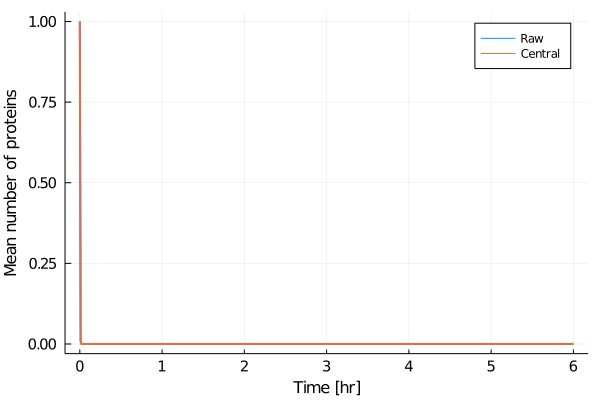

In [10]:
using Plots
plot(sol_central.t, [sol_raw[1,:], sol_central[1,:]], 
    label  = ["Raw" "Central"], 
    legend = true,
    xlabel = "Time [hr]",
    ylabel = "Mean number of proteins",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

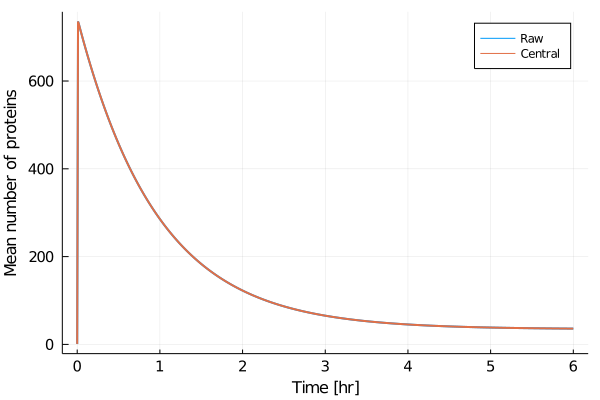

In [11]:
plot(sol_central.t, [sol_raw[2,:], sol_central[2,:]], 
    label  = ["Raw" "Central"], 
    legend = true,
    xlabel = "Time [hr]",
    ylabel = "Mean number of proteins",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)

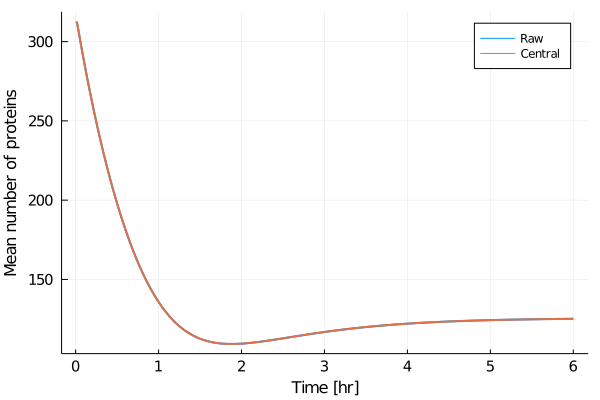

In [12]:
raw_std = sqrt.(sol_raw[4,2:end] .- sol_raw[2,2:end].^2)
central_std = sqrt.(sol_central[4,2:end])
plot(sol_central.t[2:end], [raw_std, central_std], 
    label  = ["Raw" "Central"], 
    legend = true,
    xlabel = "Time [hr]",
    ylabel = "Mean number of proteins",
    lw=2,
    legendfontsize=8,
    xtickfontsize=10,
    ytickfontsize=10,
    dpi=100)